In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

#tensorboard
%load_ext tensorboard
import datetime, os

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
# A small detail
tf.keras.backend.set_floatx('float32')

# Redes Generativas Antagónicas (Generative Adversarial Networks; GAN)

## Data (Fashion_MNIST)

Al igual que `sklearn` permite cargar conjuntos de datos estándar, también lo hace `keras`.

En general, `keras` acepta conjuntos de datos en forma de Numpy Arrays (como `sklearn`), pero también viene con una clase `Dataset` que está optimizada para cargar datos (incluso si son más grandes que la memoria RAM del ordenador).

In [28]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Como ya sabemos, en grandes conjuntos de datos la validación cruzada puede ser muy costosa, por lo que se recomienda dejar aparte un conjunto de validación del entrenamiento.

También normalizamos los píxeles (que van de 0 a 255) para que estén entre 0 y 1.

In [29]:
# Separo en entrenamiento y validacion, y normalizo los pixeles
# Los paso a 32 bits para que no haya problemas con TF.
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

(60000, 28, 28)


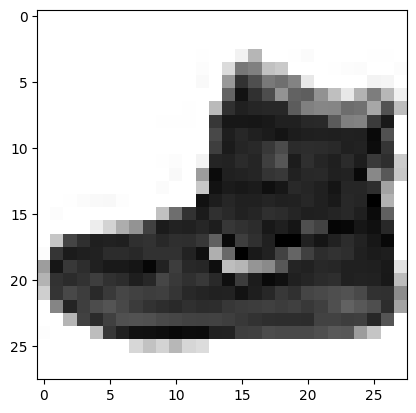

In [30]:
print(X_train_full.shape)

plt.imshow(X_train[0], cmap='binary', interpolation='None')

Los valores objetivo son numéricos, de 0 a 9. Podemos guardar las etiquetas para que nos resulte más fácil analizar lo bien o mal que funciona nuestro modelo:

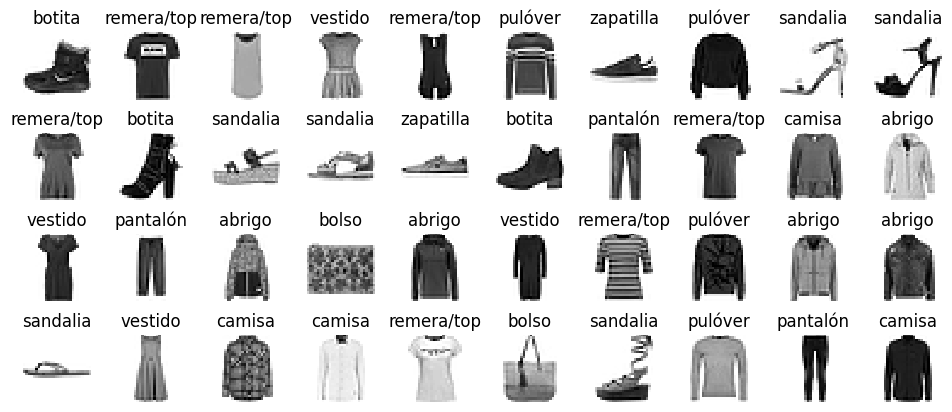

In [31]:
class_names = ["remera/top", "pantalón", "pulóver", "vestido", "abrigo",
               "sandalia", "camisa", "zapatilla", "bolso", "botita"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [32]:
# Una función útil
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Definir una GAN


In [33]:
keras.backend.clear_session()


La arquitectura es bastante sencilla. Incluso podríamos utilizar la API secuencial de `keras` (**Nota:** en realidad es más fácil con la API secuencial).

Primero definimos algunos hiperparámetros

In [34]:
# Encoding size
codings_size = 30

# Generator
gen_unit_layers = [100, 150]

# Discriminator
dis_unit_layers = [150, 100]

# Training
discriminative_batches_per_generative_batch = 1
batch_size = 32

### Red generadora

In [35]:
# Definir red generadora como decodificador de un encoder variacional
input_gen = keras.layers.Input(shape=(codings_size,), name='genin')

# Capas densas (iterar usando los hiperparámetros de la celda anterior)
in_ = input_gen
for i, u in enumerate(gen_unit_layers):
    in_ = keras.layers.Dense(u, activation="selu", name='gen{}'.format(i + 1))(in_)

# Activación sigmoide para mantener los pixels en el rango [0, 1]
# Cambiamos la forma de nuevo a la forma original
flatgenout_ = keras.layers.Dense(28 * 28, activation="sigmoid", name='genout_flat')(in_)
out_gen = keras.layers.Reshape([28, 28], name='genout')(flatgenout_)

# Construir modelo completo
generator = keras.models.Model(input_gen, out_gen, name='Generative')

# Usando API secuencial
# generator = keras.models.Sequential([
#     keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
#     keras.layers.Dense(150, activation="selu"),
#     # We use sigmoid activation in the output layer to keep pixels in the range [0, 1]
#     # Reshape back to original size
#     keras.layers.Dense(28 * 28, activation="sigmoid"),
#     keras.layers.Reshape([28, 28])
# ])

In [36]:
generator.summary()

Model: "Generative"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 genin (InputLayer)          [(None, 30)]              0         
                                                                 
 gen1 (Dense)                (None, 100)               3100      
                                                                 
 gen2 (Dense)                (None, 150)               15150     
                                                                 
 genout_flat (Dense)         (None, 784)               118384    
                                                                 
 genout (Reshape)            (None, 28, 28)            0         
                                                                 
Total params: 136634 (533.73 KB)
Trainable params: 136634 (533.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Red discriminadora

In [37]:
# El discriminador es una red para clasificación binaria
input_dis = keras.layers.Input(shape=(28, 28), name='disin')
flatin_dis = keras.layers.Flatten(name='flat')(input_dis)

in_ = flatin_dis
for i, u in enumerate(dis_unit_layers):
    in_ = keras.layers.Dense(u, activation="selu", name='dis{}'.format(i + 1))(in_)

out_dis = keras.layers.Dense(1, activation='sigmoid', name='disout')(in_)

discriminator = keras.models.Model(input_dis, out_dis, name='Discriminative')

In [38]:
discriminator.summary()

Model: "Discriminative"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 disin (InputLayer)          [(None, 28, 28)]          0         
                                                                 
 flat (Flatten)              (None, 784)               0         
                                                                 
 dis1 (Dense)                (None, 150)               117750    
                                                                 
 dis2 (Dense)                (None, 100)               15100     
                                                                 
 disout (Dense)              (None, 1)                 101       
                                                                 
Total params: 132951 (519.34 KB)
Trainable params: 132951 (519.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Construir la GAN

In [39]:
# Ahora juntamos ambas redes para hacer una GAN
# (thanks, keras API!)

# Capa de input
gan_input = keras.layers.Input(shape=(codings_size,), name='ganin')
# Generar nueva muestra con el generador
H = generator(gan_input)
# Pasarla por el discriminador
gan_output = discriminator(H)

gan = keras.models.Model(gan_input, gan_output)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ganin (InputLayer)          [(None, 30)]              0         
                                                                 
 Generative (Functional)     (None, 28, 28)            136634    
                                                                 
 Discriminative (Functional  (None, 1)                 132951    
 )                                                               
                                                                 
Total params: 269585 (1.03 MB)
Trainable params: 269585 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenamiento

Es hora de entrenar la GAN. Tenemos que proponer una función de pérdida para cada uno de los dos elementos de la GAN.

La red discriminante realiza una clasificación binaria (ni más ni menos), por lo que es natural utilizar la entropía binaria.

Por otro lado, la red generadora se entrena utilizando ambas partes del modelo, pero sin ajustar los pesos de la red D. Por lo tanto, tenemos que hacer un pequeño truco, pero es bastante sencillo con `keras`.

Vamos a utilizar un optimizador un poco más apropiado para este tipo de red: `rmsprop`

In [40]:
# Compilar discriminador
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Definir el discriminador como no entrenable (esto sólo será efectivo después de compilar)
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

De esta forma, el discriminador puede ser entrenado independientemente, pero cuando entrenemos la red GAN, sus pesos permanecerán fijos.

Ahora viene la parte complicada, porque no podemos entrenar la red con una simple llamada al método `fit`.

Primero generamos un conjunto de datos, de tamaño `batch_size`.

In [41]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Y ahora escribimos una rutina de entrenamiento adversario (suena el tema de Rocky).

In [58]:
# Codigo de Géron (https://github.com/ageron/handson-ml2), con mucho comentario propio

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50,
              dbpgb=discriminative_batches_per_generative_batch, tensorboard=None):
    generator, discriminator = gan.layers#[1:]

    # Transformar el valor de retorno de train_on_batch
    # a dict, como espera el callback on_batch_end
    def named_logs(model, logs):
      result = {}
      for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
      return result

    # Agregar modelo a Tensorboard
    if tensorboard is not None:
        tensorboard.set_model(gan)

    for epoch in range(n_epochs):
        if tensorboard is not None:
            tensorboard.set_model(gan)

        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for i, X_batch in enumerate(dataset):
            #
            # Phase 1 - train the discriminator
            # Fase 1 - entrenar el discriminador
            #

            # Create noise (samples) drawn from an isotropic multinormal
            # with same dimension as coding_size
            #
            # Genera ruido (muestras) salido de una multinormal isotrópica con
            # tamaño igual al coding_size
            codes = tf.random.normal(shape=[batch_size, codings_size])

            # Run generator to produce fake images
            # Corre el generador para producir imágenes ficticias
            generated_images = generator(codes)

            # Build dataset combining these images with real ones
            # Genera un dataset combinando estas imágenes con imágenes reales
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)

            # Make labels to identify the real ones from the fake ones
            # Genera las etiquetas que identifican como verdadero o falso
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # Esta línea es para evitar un warning, el discriminador ya es
            # entrenable
            # discriminator.trainable = True

            # Train the discriminator
            # Entrena al discriminador
            discriminator.train_on_batch(X_fake_and_real, y1)

            # Every generative_batches_per_discriminative_batch, train also G
            if (i+1) % dbpgb == 0:
                #
                # Phase 2 - train the generator
                #
                # More noise (they are actually samples in the latent space!)
                # Más ruido (en realidad muestras en el espacio latente!)
                codes = tf.random.normal(shape=[batch_size, codings_size])

                # Labels (this time, true for all)
                y2 = tf.constant([[1.]] * batch_size)

                # Otra vez, para evitar un warning
                # discriminator.trainable = False

                # Train full model (generator + discriminator) with these labels

                # Entrena todo el modelo: generador + discriminador, con esas
                # etiquetas
                logs = gan.train_on_batch(codes, y2)

                #
                # Tensorboard
                if tensorboard is not None:
                    tensorboard.on_epoch_end(epoch, named_logs(gan, [logs,]))

        if tensorboard is not None:
            tensorboard.on_train_end(None)

        # Ver algunas imágenes
        plot_multiple_images(generated_images, 8)
        plt.show()

Vamos a entrenarla y a ver las imágenes generadas por la red G.

In [46]:
# tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 3746), started 0:07:56 ago. (Use '!kill 3746' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
# tensorboard_callback.set_model(generator)

Epoch 1/2


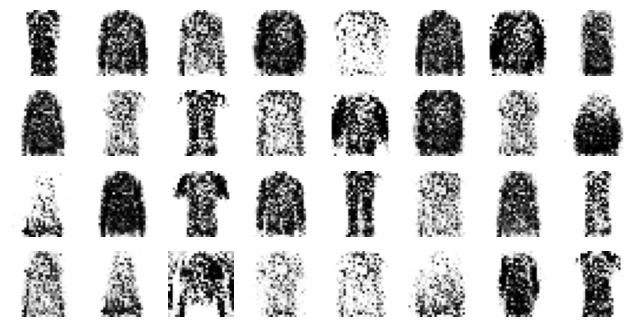

Epoch 2/2


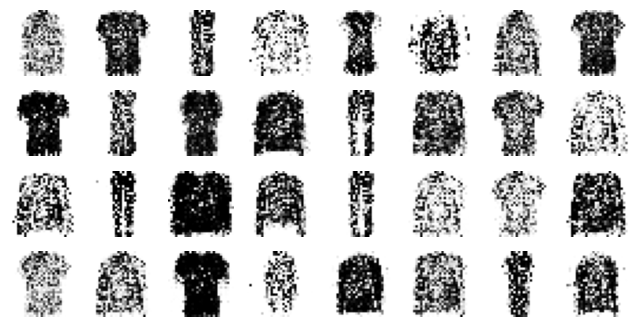

In [47]:
 train_gan(gan, dataset, batch_size, codings_size, n_epochs=2)

Epoch 1/10


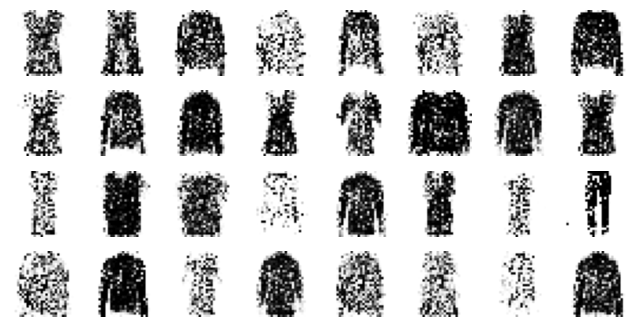

Epoch 2/10


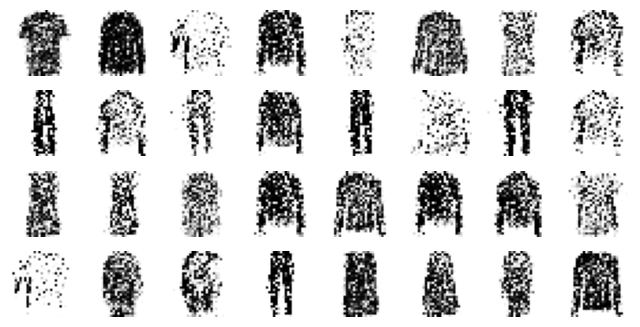

Epoch 3/10


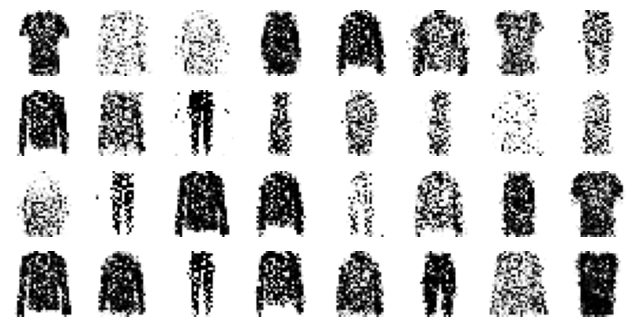

Epoch 4/10


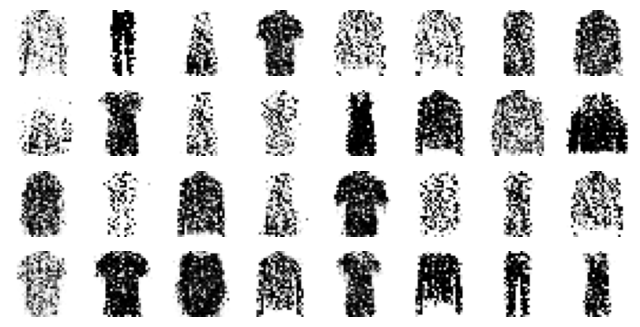

Epoch 5/10


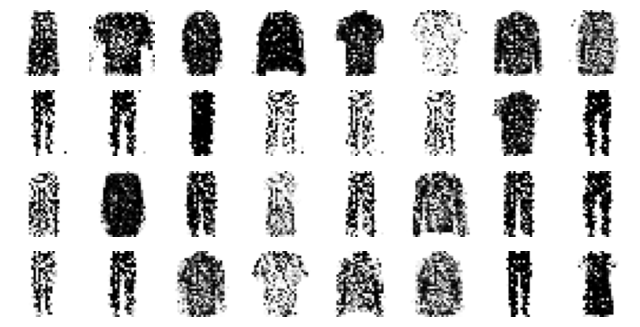

Epoch 6/10


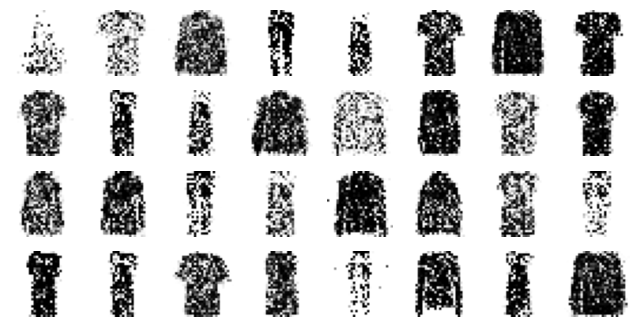

Epoch 7/10


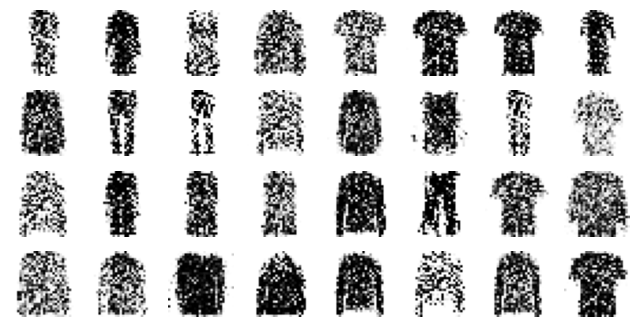

Epoch 8/10


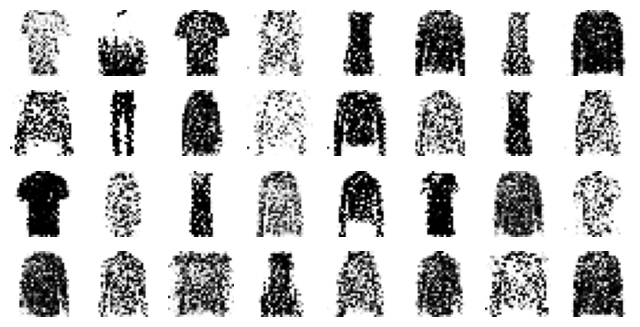

Epoch 9/10


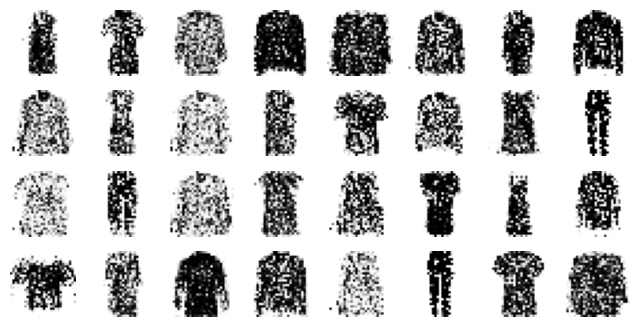

Epoch 10/10


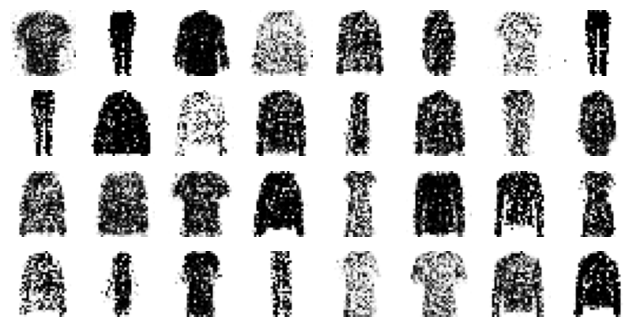

In [48]:
# Ahora entrenamos durante más tiempo y utilizamos TensorBoard para seguir la evolución.
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10, tensorboard=tensorboard_callback)

In [49]:
gan.save('models/gan_model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## GAN convolucional profunda (DCGAN)

Por supuesto, podemos hacer un trabajo similar (mejor) utilizando CNNs.

In [50]:
keras.backend.clear_session()

In [51]:
# Codigo de Géron (https://github.com/ageron/handson-ml2)
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
dcgan = keras.models.Sequential([generator, discriminator])

In [52]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [53]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [54]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [55]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

In [ ]:
train_gan(dcgan, dataset, batch_size, codings_size, tensorboard=tensorboard_callback, n_epochs=5)

Epoch 1/5


In [ ]:
codes = tf.random.normal(shape=[1,codings_size])
fake_img = generator(codes)

#print(codes)

plt.imshow(fake_img[0,:,:,0], cmap='binary')
plt.axis("off")